## Understanding ROMP configurations and parameters

All package parameters are set in `params/config.in` by default. Users need to make sure they are properly set for their project before running the package - that's the first thing to do after installation.   

Once we get quite familiar with ROMP, there is an option to make an edited copy of the config file outside of the sitepackage, with user defiend  filename such as `config_project_name.in` (not recommended for new users).

---
### 1. Workflow Structure & Dimensions  

This section initializes the project metadata and defines the global dimensions of the evaluation. It serves as the registry for which forecast models will be included in the current run.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **project_name** | `String` | A descriptive title for your experiment. This is often used in plot titles and log files. |
| **layout** | `Tuple` | Defines the internal workflow structure for benchmarking. Standardized as `("model", "verification_window")`. |
| **model_list** | `Tuple` | The list of forecast models to be processed (e.g., `"IFS"`, `"NGCM"`). |

#### Key Concepts

##### 1. The Importance of "Forecast Categories"
When defining your `model_list`, all models must belong to the same **forecast category**. 
* **Example**: Do not mix deterministic models (single output) with probabilistic/ensemble models (multiple outputs) in the same run, as the verification metrics (like MAE vs. RPSS) differ significantly.

##### 2. Layout & Dimensions
The `layout` parameter is "frozen" for major versions of the ROMP package. It tells the system how to organize the resulting multidimensional arrays (tensors). 
* **Model**: The identifier for the forecast source.
* **Verification Window**: The specific time slice (e.g., Day 1-3, Week 1) being evaluated.



#### Rules for Tuples in Python Configs
The system uses Python's `tuple` syntax for many parameters. Note these two critical formatting rules:

1.  **Trailing Commas**: If you are only evaluating **one** model, you must keep a trailing comma so Python recognizes it as a tuple:
    * `model_list = ("IFS",)` $\leftarrow$ Correct
    * `model_list = ("IFS")` $\leftarrow$ **Incorrect** (Python will treat this as a simple string)
2.  **Consistency**: The number of entries in `model_list` must exactly match the number of entries in the subsequent `_list` parameters (like `model_dir_list` and `model_var_list`).




---
### 2. Observation Data Settings  

This section defines how the system locates, reads, and interprets the "Ground Truth" or observational data.   

#### Parameter Breakdown


| Parameter | Type | Description |
| :--- | :--- | :--- |
| **obs** | `String` | Unique identifier for the dataset (e.g., "IMD", "CHIRPS"). |
| **obs_dir** | `Path` | Root directory for observational NetCDF files. |
| **obs_file_pattern** | `Tuple` | File naming pattern. `{}` is a placeholder for date/year. |
| **obs_var** | `String` | The specific variable name for rainfall inside the NetCDF file. |
| **obs_unit_cvt** | `Float/None` | Multiplier for unit conversion (e.g., 1000 to convert m to mm). |

<br>

#### Implementation Notes & Limitations

* **Variable Names**: `obs_var` must exactly match the variable name in your NetCDF file metadata.
* **Placeholders**: The `{}` in `obs_file_pattern` is dynamically filled by the processing script. If your files are named by year (e.g., `1998.nc`), the pattern should be `("{}.nc",)`.
* **Unit Conversion**: Set `obs_unit_cvt` to `None` if your data is already in the target units (usually mm). Use a float like `1000.0` if the source data is in meters.  

#### Verification example:

In [1]:
import os

# Example values from your config
obs = "IMD"
obs_dir = "data/obs"
obs_file_pattern = ("{}.nc", "data_{}.nc")

# Simulation of file look-up for the year 2024
example_year = "2024"
potential_file = obs_file_pattern[0].format(example_year)
full_path = os.path.join(obs_dir, potential_file)

if os.path.exists(full_path):
    print(f"✅ Success: Found file at {full_path}")
else:
    print(f"❌ Error: Could not find {full_path}. Check your 'obs_dir' or 'obs_file_pattern'.")

❌ Error: Could not find data/obs/2024.nc. Check your 'obs_dir' or 'obs_file_pattern'.


<br> 

---  

### 3. Reference Model (Benchmark) Settings

This section explains how to set a benchmark (like a historical average or a simpler model) to evaluate your main model's performance.  

The reference model provides a baseline for evaluating the performance of your target model. A common practice is to use **Climatology** (long-term historical averages) as the benchmark.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **ref_model** | `String` | The identifier for your benchmark. Use `"climatology"` or a specific model name. |
| **ref_model_dir** | `Path` | Directory where the reference NetCDF files are located. |
| **ref_model_file_pattern** | `Tuple` | Naming convention for reference files. Uses `{}` for date/year placeholders. |
| **ref_model_var** | `String` | The rainfall variable name within the reference NetCDF file. |
| **ref_model_unit_cvt** | `Float/None` | Scaling factor for reference data (e.g., use `1000` if the reference is in meters). |

---

#### Why use a Reference Model?

The benchmark allows you to calculate "Skill Scores." Instead of just knowing if your model is accurate, you learn if it is *better* than a simple baseline.

* **Climatology**: If `ref_model = "climatology"`, the system typically compares results against the long-term mean of the observation data.
* **Persistence**: You might use a previous day/year as a reference to see if the model adds value beyond simply repeating the past.



#### Configuration Tips

1.  **Shared Directories**: It is common for `ref_model_dir` to be the same as `obs_dir` if you are using historical observational data as your climatology baseline.
2.  **Consistency**: Ensure `ref_model_var` and `ref_model_unit_cvt` result in the same physical units as your observation and forecast data. If the units don't match, the error metrics (like RMSE or Bias) will be mathematically invalid.
3.  **File Pattern**: Like the observation section, the `{}` placeholder ensures the script can iterate through multiple years of benchmark data automatically.

<br>

---
### 4. Forecast Model Settings  

This section is crucial as it handles the "Forecast Models" you are evaluating. Unlike the observation and reference sections, these settings are formatted as Lists of Tuples because the pipeline can process multiple models (e.g., IFS and NGCM) simultaneously for comparison.  

This section allows you to define one or more forecast models for evaluation. Because you may want to compare multiple models at once, these parameters are defined as **Tuple lists**.  

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **model_dir_list** | `Tuple` | Directories for each forecast model. Order must match your model list. |
| **model_var_list** | `Tuple` | The rainfall variable name in each model's NetCDF file (e.g., `"tp"` for Total Precipitation). |
| **unit_cvt_list** | `Tuple` | Conversion factors for each model. Use `None` if units are already in mm. |
| **file_pattern_list** | `Tuple` | File naming patterns for each model. Uses `{}` for time-based placeholders. |

---

#### Handling Multiple Models - understanding the mapping

The power of this section lies in its **parallel structure**. Each item in the first list corresponds to the same index in the other lists. The system matches these parameters by their **index** (their position in the tuple).  

**Example Scenario:**
* **Model 1 (IFS):** Uses variable `tp`, stored in `data/ifs`.
* **Model 2 (NGCM):** Also uses variable `tp`, stored in `data/ngcm`.

**Example Mapping:**
* **Index 0**: `model_dir_list[0]` $\rightarrow$ `model_var_list[0]` $\rightarrow$ `unit_cvt_list[0]`
* **Index 1**: `model_dir_list[1]` $\rightarrow$ `model_var_list[1]` $\rightarrow$ `unit_cvt_list[1]`


#### Limitations & Potential Errors

1.  **Index Mismatch**: If `model_dir_list` has 3 paths but `model_var_list` only has 2 names, the notebook will crash with an `IndexError`. **Always ensure all lists have the same length.**
2.  **Variable Variations**: Note that while the variable name is often the same (e.g., `"tp"`), different centers (ECMWF vs. NCEP) might use different default units.
    * *Tip:* Check if one model is in **meters** (requires `unit_cvt = 1000`) and the other is already in **mm** (requires `None`).
3.  **File Naming**: If Model A uses `YYYY.nc` but Model B uses `model_YYYY.nc`, you must reflect this in the `file_pattern_list` using `("{}.nc", "model_{}.nc")`.
4.  **Immutability**: Since these are defined as **Tuples** (using parentheses `()`), they cannot be changed globally once the script starts running. If you need to add a model dynamically during a session, you would need to redefine the entire tuple.

#### Unit Consistency Check
A common mistake in forecast evaluation is comparing "Precipitation Rate" (mm/day, kg/m2/s) with "Total Accumulation" (mm). Check your metadata to ensure the `unit_cvt_list` brings all models to a consistent **mm/day** or **mm/period** basis.

<br>

---
### 5. Region & Threshold Definitions  

This section defines the spatial boundaries for your analysis. The tool provides three independent methods—**Region**, **Shapefile**, and **Polygon Masking**—to subset or mask your data.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **region** | `String` | Required. Defines a target area (e.g., "Ethipoia"). This typically pulls predefined coordinates from a separate settings file. |
| **shpfile_dir** | `Path` | Specifies a directory containing shapefiles to define the boundary. |
| **polygon** | `Boolean` | If `True`, the system applies a precise polygon-based mask using definitions found in `params/region_def`. |

---

#### Three Methods of Spatial Definition

The package uses these parameters to determine which grid points to include in the evaluation:

1.  **Region-Based**: Uses a named geographic area. This is often the simplest method, relying on hardcoded latitude/longitude bounds for well-known areas.
2.  **Shapefile-Based**: Uses the physical `.shp` files located in `shpfile_dir`. This allows you to use external GIS data to define the study area.
3.  **Polygon Masking**: When `polygon = True`, the system moves beyond a rectangular "bounding box" and masks the data to the exact edges of the region polygons. This ensures that only data points strictly inside the boundary are calculated.



#### Configuration Rules & Limitations

* **Independence**: These methods can be used independently depending on your project needs. 
* **Polygon Requirements**: If `polygon` is set to `True`, you **must** have the corresponding definitions set up in `params/region_def`.
* **Data Alignment**: Ensure your NetCDF grid resolution is sufficient for your chosen boundary. If your region is very small (e.g., a small district) and your model resolution is coarse (e.g., 1 degree), you may end up with very few data points for analysis.
* **Pathing**: Double-check that `shpfile_dir` points to a folder containing all the required shapefile components (`.shp`, `.shx`, `.dbf`).

<br>

---
### 6. Rainy season/Monsoon Onset Criteria (Physics Logic)

This section defines the meteorological "rules" that determine the onset of the rainy season or monsoon. The logic typically involves identifying a transition from a dry state to a sustained wet state, while ensuring that "false starts" (isolated rain events) are filtered out.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **wet_init** | `Float` | The minimum rain (mm) required to trigger the "potential" start of the onset. |
| **wet_threshold** | `Float` | The required accumulated rainfall (mm) over a period to confirm onset. |
| **wet_spell** | `Integer` | The minimum number of days the wet conditions must persist. |
| **dry_threshold** | `Float` | The maximum rainfall (mm) allowed to still consider a day "dry." |
| **dry_spell** | `Integer` | The maximum allowed consecutive dry days immediately following a potential onset. |
| **dry_extent** | `Integer` | The search window (days) to look for a dry spell. Set to `0` to disable the dry-spell check. |
| **thresh_file** | `Path/None` | Path to a NetCDF containing spatially varying thresholds. If `None`, `wet_threshold` is used globally. |
| **thresh_var** | `String` | The variable name for the threshold inside the `thresh_file`. |
| **onset_percentage_threshold** | `Float` | For ensembles: The fraction of members (0.0–1.0) that must agree on onset for it to be official. |

---

#### The Onset Logic Flow

The algorithm generally follows these steps to identify the onset date:
1. **Initial Trigger**: Finds the first day where rainfall exceeds `wet_init`.
2. **Accumulation Check**: Ensures the total rain over the period reaches `wet_threshold`.
3. **Persistence (Wet Spell)**: Checks if the wet conditions last for at least `wet_spell` days.
4. **False-Start Filtering (Dry Spell)**: If `dry_extent` is greater than 0, the search looks ahead. If a dry spell longer than `dry_spell` occurs within the `dry_extent` window, the initial trigger is rejected as a "false onset."



#### Spatial vs. Scalar Thresholds

Precipitation varies wildly by geography (e.g., the Western Ghats vs. Rajasthan). 
* **Scalar**: Using `wet_threshold = 10` applies the same 10mm rule to every grid point.
* **Spatial**: By providing a `thresh_file` (a netcdf file with 2-D lat/lon rainfall threshold field), the system uses a unique threshold for every pixel based on historical climatology (`thresh_var`). This is much more scientifically robust for large regions like India.

#### Working with Ensembles
If you are using probabilistic models (ensembles), `onset_percentage_threshold` is key. 
* If set to `0.5`, the onset date is only recorded for a grid point when **50% or more** of the ensemble members agree that the onset criteria have been met.



<br>

#### Application Example: Translating Scientific Definitions to Config Settings

To better understand Section 6, let's translate a common scientific definition of monsoon onset into the specific parameters used by this package.

##### The Objective
> "Identify the first wet day (**≥1 mm**) of the first **5-day** wet sequence from **April 1st 2025** that receives at least the **climatological onset amount** in April–October without being followed by a **10-day dry spell** (receiving **less than 5 mm**) in the following **30 days**."

##### The Configuration Translation

To implement the logic above, your `config.in` (and the related Section 7 dates) should be set as follows:

| Scientific Requirement | Config Parameter | Setting |
| :--- | :--- | :--- |
| First wet day (≥1 mm) | `wet_init` | `1` |
| 5-day wet sequence | `wet_spell` | `5` |
| Climatological amount | `thresh_file` | `"data/climatology_thresholds.nc"` |
| Use scalar if no file | `wet_threshold` | *(Used only if thresh_file not provided)* |
| 10-day dry spell | `dry_spell` | `10` |
| Less than 5 mm | `dry_threshold` | `5` |
| Following 30 days | `dry_extent` | `30` |
| April 1st start | `start_date` | `(2025, 4, 1)` |


Note for `start_date` setting, see section 7.  

##### Visualizing the Logic Flow



1.  **Search Start**: The algorithm begins scanning from your `start_date` (April 1st).
2.  **The Trigger**: It looks for a day where rain $\ge$ `wet_init` (1 mm).
3.  **Sustainability**: Once triggered, it checks the next `wet_spell` (5 days). The total rain in these 5 days must exceed the value found in your `thresh_file`.
4.  **The "False Start" Check**: After the 5-day wet spell, the algorithm looks ahead for `dry_extent` (30 days). If it finds a sequence of `dry_spell` (10 days) where each day is below `dry_threshold` (5 mm), the onset is **rejected** as a false start, and the search continues.  


##### Pro-Tip: The `dry_extent` Requirement
A common mistake is setting `dry_extent` too short. For the logic above, `dry_extent` must be at least **30** days. If you set it to `5`, the "10-day dry spell" rule will be completely ignored, potentially leading to "False Onsets" caused by pre-monsoon thundershowers.

##### Below is an example with dummy data and time series plot:

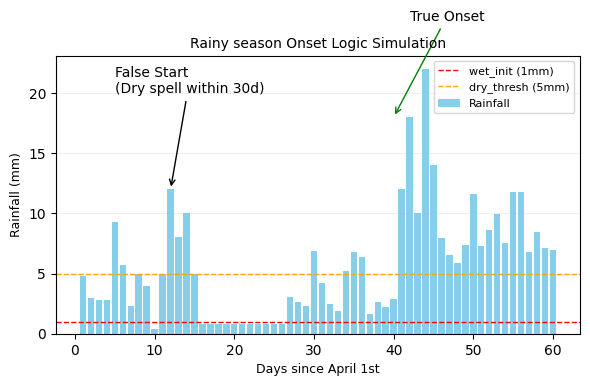

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup synthetic data (60 days) - Adjusted for a smaller display
np.random.seed(42)
days = np.arange(1, 61)
rain = np.random.gamma(2, 2, 60) 

# Insert False Start (Day 10)
rain[10:15] = [5, 12, 8, 10, 5]   
rain[15:26] = 0.8                # Followed by a long dry spell

# Insert True Onset (Day 40)
rain[40:45] = [12, 18, 10, 22, 14] 
rain[45:60] = np.random.uniform(5, 12, 15)

# 2. Plotting with reduced figsize (approx half-size)
plt.figure(figsize=(6, 4))
plt.bar(days, rain, color='skyblue', width=0.8, label='Rainfall')

# Threshold lines
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='wet_init (1mm)')
plt.axhline(y=5, color='orange', linestyle='--', linewidth=1, label='dry_thresh (5mm)')

# Simplified Annotations
plt.annotate('False Start\n(Dry spell within 30d)', xy=(12, 12), xytext=(5, 20),
             arrowprops=dict(arrowstyle='->', color='black'))
plt.annotate('True Onset', xy=(40, 18), xytext=(42, 26),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.title("Rainy season Onset Logic Simulation", fontsize=10)
plt.xlabel("Days since April 1st", fontsize=9)
plt.ylabel("Rainfall (mm)", fontsize=9)
plt.legend(fontsize=8, loc='best')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout() # Ensures labels aren't cut off in small plots
plt.show()

#### Summary of the "Onset Loop"
When you run the model with these settings, the code performs the following logical loop for every grid point:

1.  **Candidate Selection**: Is `Rain[day] >= wet_init`? 
2.  **Wet Validation**: Is `Sum(Rain[day : day + wet_spell]) >= wet_threshold`?
3.  **Stability Check**: 
    * Look forward for `dry_extent` days.
    * Search for any sequence of `dry_spell` consecutive days where `Rain < dry_threshold`.
    * **If found**: Rejection. The "onset" was a pre-monsoon shower. Restart search from next day.
    * **If NOT found**: Success! The current `day` is recorded as the **Onset Date**.

> **Tutorial Note**: Adjusting `dry_extent` and `dry_spell` is the most effective way to tune the model for specific geographic regions (like the difference between the onset in Kerala vs. Northeast India).

<br>

---
### 7. Temporal Settings (Dates & Years)

This section manages the time-windows for both your forecast evaluation and your climatological baseline. It also handles the logic for "Initialization Days," which is crucial for sub-seasonal to seasonal (S2S) models that only run on specific days of the week.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **start_date / end_date** | `Tuple` | The full range for evaluation (Year, Month, Day). |
| **start_year_clim / end_year_clim** | `Integer` | The year range used to calculate the historical mean. |
| **years** | `Tuple` | (Optional) Manually specify which years to analyze, overriding the range. |
| **years_clim** | `Tuple` | (Optional) Manually specify years for the climatology baseline. |
| **init_days** | `Tuple` | Days of the week the model is initialized (0=Monday, 3=Thursday). |
| **date_filter_year** | `Integer` | A reference year used to map calendar dates to specific weekdays. |

---

#### Climatology vs. Evaluation Period

It is vital to distinguish between these two timeframes:
1.  **Evaluation Period**: The specific days/years you are benchmarking the model's accuracy (e.g., 2013–2015).
2.  **Climatological Period**: The years used to define "normal" rainfall. Usually, this is a much longer period (e.g., 30 years), but in the config template, it is matched to the evaluation years.
3.  **years** and **years_clim** are optional. By default, a list of consecutive years are created according to **start_date / end_date** and **start_year_clim / end_year_clim**, but can be overiden by list of specific years (not necessary in consecutive order) as in **years** and **years_clim**. Set to `None` if not used in the package. 



#### The Initialization Filter

Most S2S forecast models (like the IFS) do not run every day. They might only run twice a week.
* **`init_days = (0, 3)`**: This tells the script to only look for forecast data initialized on **Mondays** and **Thursdays**.
* **`date_filter_year`**: Because the date of a "Monday" changes every year, the system uses a reference year (e.g., 2024) to lock in the `MM/DD` combinations. For example, if May 6th was a Monday in 2024, the script will look for May 6th in 2013, 2014, and 2015 as an initialization candidate.

#### Limitations & Tips

* **Leap Years**: The system automatically handles February 29th, but ensure your `start_date` and `end_date` cover the full monsoon season (typically May through October for the Indian Monsoon).
* **Trailing Commas**: If your model only initializes on one day (e.g., only Monday), remember the tuple rule: `init_days = (0,)`.



<br>

---
### 8. Evaluation & Verification Parameters

This section defines the "resolution" of your evaluation in terms of time (temporal metrics for success.). It determines how far into the future the model is tested and how much "wiggle room" (tolerance) is allowed for a forecast to be considered correct.  Since weather forecasts naturally degrade over time, these parameters allow you to analyze model skill at different "lead times" (how far in advance the forecast was made).

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **verification_window_list** | `Tuple of Tuples` | Specific ranges of days post-initialization to evaluate (e.g., Week 1 vs. Week 2). |
| **tolerance_days_list** | `Tuple` | The "margin of error" allowed in a verification window. If the model predicts onset 3 days late, it is "correct" if tolerance is $\ge 3$. |
| **max_forecast_day** | `Integer` | The absolute limit of the forecast data (e.g., a 15-day or 30-day forecast). |
| **day_bins** | `Tuple of Tuples` | Smaller sub-windows used for grouping probabilistic statistics and plotting. |



#### Understanding Verification Windows vs. Bins

While they look similar, they serve different purposes:

1.  **Verification Windows**: These are the "Macro" windows. You might want to see how the model performs in the first two weeks (`1, 15`) versus the second two weeks (`16, 30`). The model's skill is usually much higher in the first window.
2.  **Day Bins**: These are the "Micro" windows for grouping **probabilistic forecast** statistics. They are used to group daily data into chunks (like 5-day intervals) for metric statistics and plots.


#### The Tolerance Factor

The `tolerance_days_list` is critical for calculating "Hit Rates." 
* A tolerance of **0** means the forecast must match the observation exactly.
* A tolerance of **3** means if the observed onset is June 5th, any forecast between June 2nd and June 8th is considered a "Hit."

#### Constraints & Limitations

* **Alignment**: The `max_forecast_day` must not exceed the actual length of your NetCDF forecast files. If your files only contain 15 days of data, setting this to 30 will cause the script to look for non-existent data.
* **Overlap**: Ensure your `day_bins` fit within your `max_forecast_day`. For example, if `max_forecast_day` is 15, your bins shouldn't go up to 20.
* **Tuple Formatting**: Note the double parentheses for nested ranges: `((start, end), (start, end))`.



<br>

---
### 9. Metrics Selection

This section defines the statistical "grading system" for your models. It allows you to toggle specific performance metrics on or off depending on whether you are evaluating a single forecast (Deterministic) or a collection of forecasts (Probabilistic/Ensemble). The flags acts as toggle switches for the various statistical analyses the pipeline will perform. It is divided into two main categories: **Deterministic** (focused on error and accuracy) and **Probabilistic** (focused on uncertainty and reliability).

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **FAR** | `Boolean` | **False Alarm Ratio**: How often the model predicted an onset that didn't happen. |
| **MAE** | `Boolean` | **Mean Absolute Error**: The average number of days the forecast was off. |
| **MR** | `Boolean` | **Miss Rate**: How often the monsoon started but the model failed to predict it. |
| **probabilistic** | `Boolean` | Set to `True` if you are evaluating an **Ensemble** model. |
| **members** | `Tuple/Str` | A list of specific IDs for ensemble members to be included in the calculation. |



#### Deterministic vs. Probabilistic Evaluation

The metrics you choose depend heavily on the nature of your forecast:

1.  **Deterministic Metrics (`probabilistic = False`)**:
    Best for single-trajectory models (e.g., a single high-resolution run). These metrics measure the direct distance between the forecast date and the observed date.
    

2.  **Probabilistic Metrics (`probabilistic = True`)**:
    Used when you have multiple versions of the same forecast (Ensembles). 
    * **Brier Score (BS)**: Measures the accuracy of probability forecasts.
    * **Ranked Probability Score (RPS)**: Evaluates the entire probability distribution.
    * **Reliability**: Generates data for Reliability Diagrams to see if the model is "overconfident" or "underconfident."
    

#### Configuration Logic

* **The Member List**: If `probabilistic = True`, the script looks for the specific member IDs listed in `members`. It can take a tuple of integers e.g., `(1, 5, 7, 9)`, a str specifying member ID range e.g., `"1-5"`. If set to `None` or `'All'` or `''`, the benchmark takes all members available in the data. 
* **Skill Scores**: Setting `skill_score = True` typically calculates how much better your forecast is compared to the `ref_model` defined in Section 3.
* **Resource Management**: Calculating probabilistic metrics like **AUC** and **Reliability** is computationally expensive. If you are processing a very large geographic region, turning these off can speed up the execution during the testing phase.



<br>

---
### 10. Output & Graphics Settings

This final section of the configuration determines how your results are stored and visualized. It allows you to toggle between raw data exports (NetCDF/CSV) and various scientific visualization styles. This section manages the "End Products" of your analysis. You can choose to save raw processed data for further use in GIS software or generate publication-ready figures directly within the pipeline.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **dir_out / dir_fig** | `String` | Directories where data files and images will be saved, respectively. |
| **save_fig** | `Boolean` | Master switch to enable or disable all image generation. |
| **save_nc_...** | `Boolean` | Exports processed spatial metrics (like MAE or Climatology) as NetCDF files. |
| **save_csv_score** | `Boolean` | Exports tabular skill scores, useful for external analysis in Excel or Pandas. |

---

#### Visualization Options

The pipeline offers several specialized meteorological plots. Setting these to `True` will generate them automatically:

* **Spatial Maps**: Visualizes errors (MAE, FAR, MR) or Climatology onset dates across the geographic grid.
    
* **Heatmaps**: Excellent for comparing multiple models or different lead times at a glance. "Panel" heatmaps group several metrics into a single figure.
    
* **Reliability Curves**: Essential for probabilistic forecasts to check if the forecast probability matches the observed frequency.
* **Bar Plots**: Best for comparing summary scores like Brier Skill Score (BSS) or Area Under Curve (AUC) across different model versions.

#### Best Practices for Output

1.  **Storage Space**: Saving spatial metrics as NetCDF (`save_nc_... = True`) can consume significant disk space if you are working with high-resolution global data over many years.
2.  **Workflow Efficiency**: During the initial setup or debugging phase, it is often helpful to set `plot_... = False` to speed up the script execution. Once the logic is verified, toggle them to `True` for the final run.
3.  **Directory Creation**: Ensure the directories defined in `dir_out` and `dir_fig` exist in your project folder, or that the script has the permissions to create them.



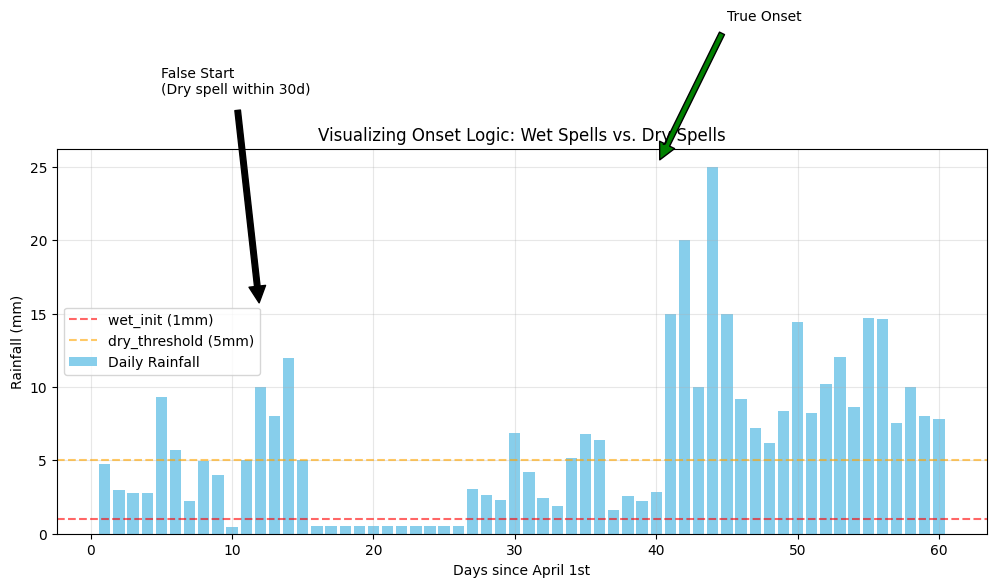

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup synthetic data (60 days of rainfall)
np.random.seed(42)
days = np.arange(1, 61)
rain = np.random.gamma(2, 2, 60)  # Low background rain

# Manually insert a "False Start" (Wet but followed by dry)
rain[10:15] = [5, 10, 8, 12, 5]   # Hits wet_threshold
rain[15:26] = 0.5                # Followed by 11-day dry spell

# Manually insert "True Onset"
rain[40:45] = [15, 20, 10, 25, 15] # Hits wet_threshold
rain[45:60] = np.random.uniform(5, 15, 15) # Stays wet

# 2. Parameters from Section 6
wet_init = 1
wet_threshold = 30 # example climatological threshold
wet_spell = 5
dry_threshold = 5
dry_spell = 10
dry_extent = 30

# 3. Visualization
plt.figure(figsize=(12, 5))
plt.bar(days, rain, color='skyblue', label='Daily Rainfall')
plt.axhline(y=wet_init, color='red', linestyle='--', alpha=0.6, label='wet_init (1mm)')
plt.axhline(y=dry_threshold, color='orange', linestyle='--', alpha=0.6, label='dry_threshold (5mm)')

# Annotate logic
plt.annotate('False Start\n(Dry spell within 30d)', xy=(12, 15), xytext=(5, 30),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('True Onset', xy=(40, 25), xytext=(45, 35),
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.title("Visualizing Onset Logic: Wet Spells vs. Dry Spells")
plt.xlabel("Days since April 1st")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Summary of the "Onset Loop"
When you run the model with these settings, the code performs the following logical loop for every grid point:

1.  **Candidate Selection**: Is `Rain[day] >= wet_init`? 
2.  **Wet Validation**: Is `Sum(Rain[day : day + wet_spell]) >= wet_threshold`?
3.  **Stability Check**: 
    * Look forward for `dry_extent` days.
    * Search for any sequence of `dry_spell` consecutive days where `Rain < dry_threshold`.
    * **If found**: Rejection. The "onset" was a pre-monsoon shower. Restart search from next day.
    * **If NOT found**: Success! The current `day` is recorded as the **Onset Date**.

> **Tutorial Note**: Adjusting `dry_extent` and `dry_spell` is the most effective way to tune the model for specific geographic regions (like the difference between the onset in Kerala vs. Northeast India).